In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bayesinsight import BayesInsightModel
import matplotlib.pyplot as plt
import numpyro
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

# Start by Loading a Dataset 
This is just a folder that contains the mff with the file name data.csv and a metadata json file
Running the following command 
```python
BayesInsightModel.new_from_dataset("path/to/data", output='model_name')
```
will create a template for you to use to build your model

In [3]:
BayesInsightModel.new_from_dataset("complex_model/data", output="example_model")

You should now have a folder called **example_model** in your local directory. Your data and metadata now lives in the **data** subdirectory. You also should see a file called **model_def.json**. This is where the model can be defined currently there is a placeholder that must be edited for the model to run.

**See the README for more detail**

For now, lets open up a model that was already setup it's in a folder called **complex_model**.
Take a look at the **model_def.json** file. 

***Hint** if you are using vscode you can right click in the file and select format document in the drop down to make the file more human readable*

You will see I have 3 variables defined in the variable details list. One control variable Promotions_Total_Total_Total, one media variable media_var_0_Total_Total_Total, and one exog variable Stock_Total_Total_Total.

Media variables are special they receive media transforms such as deminishing return curves and adstock.
Exog variables define the likelihood for the model and are similar to the dependent variables in an AWB model.
Control variables can be used to define other independant variables that are in the model.


Let's load up the model now!

In [14]:
my_model = BayesInsightModel.load("complex_model")

In [15]:
my_prior = my_model.get_prior_predictive()

Sampling: [LLT_LLT::splines_beta_mu, LLT_LLT::splines_betas, LLT_LLT::splines_betas_sd, LLT_LLT::tau, Promotion_Total_Total_Total_fixed_coeff, Promotion_Total_Total_Total_rand_coeff, Promotion_Total_Total_Total_rand_coeff_sigma, Stock_Total_Total_Total_likelihood, annual_seasonality_0_fixed_coeff, annual_seasonality_1_fixed_coeff, annual_seasonality_2_fixed_coeff, annual_seasonality_3_fixed_coeff, annual_seasonality_4_fixed_coeff, annual_seasonality_5_fixed_coeff, annual_seasonality_6_fixed_coeff, annual_seasonality_7_fixed_coeff, annual_seasonality_8_fixed_coeff, annual_seasonality_9_fixed_coeff, intercept_fixed_coeff, intercept_rand_coeff, intercept_rand_coeff_sigma]


In [16]:
import pymc as pm

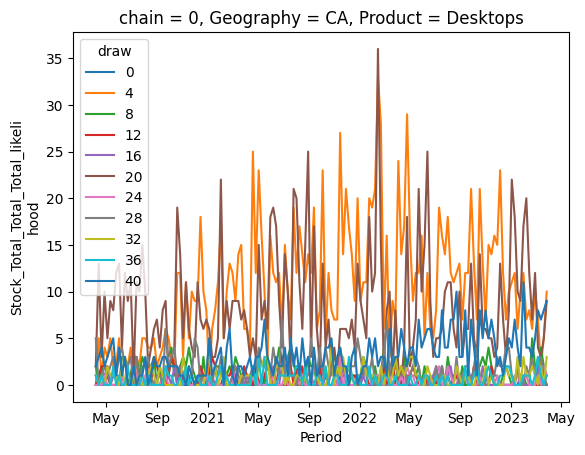

In [17]:
my_prior.prior_predictive.Stock_Total_Total_Total_likelihood.sel(chain=0, draw=slice(0, 40, 4), Geography='CA', Product="Desktops").plot(x="Period", hue='draw');

## Now we just fit the model

In [20]:
my_model.fit(nuts_sampler='numpyro', overwrite=True)  # We can change the sampler settings by passing arguments to fit
# e.g. my_model.fit(draws=2000, tune=1000, chains=4, overwrite=True) to run 4 chains
# of 2000 draws each with 1000 tuning steps and allow the model to overwrite the existing results
# this may take a while go grab a coffee

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 936 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Assuming that went well let's checkout how our model did

In [ ]:
%%sh
curl --location 'https://backend.epochlag.com/api/cards' \
--form 'title=""' \
--form 'description=""' \
--form 'tags="[\"birthday\"]"' 

curl: (26) Failed to open/read local data from file/application


CalledProcessError: Command 'b'curl --location \'https://backend.epochlag.com/api/cards\' \\\n--form \'title=""\' \\\n--form \'description=""\' \\\n--form \'tags="[\\"birthday\\"]"\' \\\n--form \'file=@"/path/to/file"\'\n'' returned non-zero exit status 26.

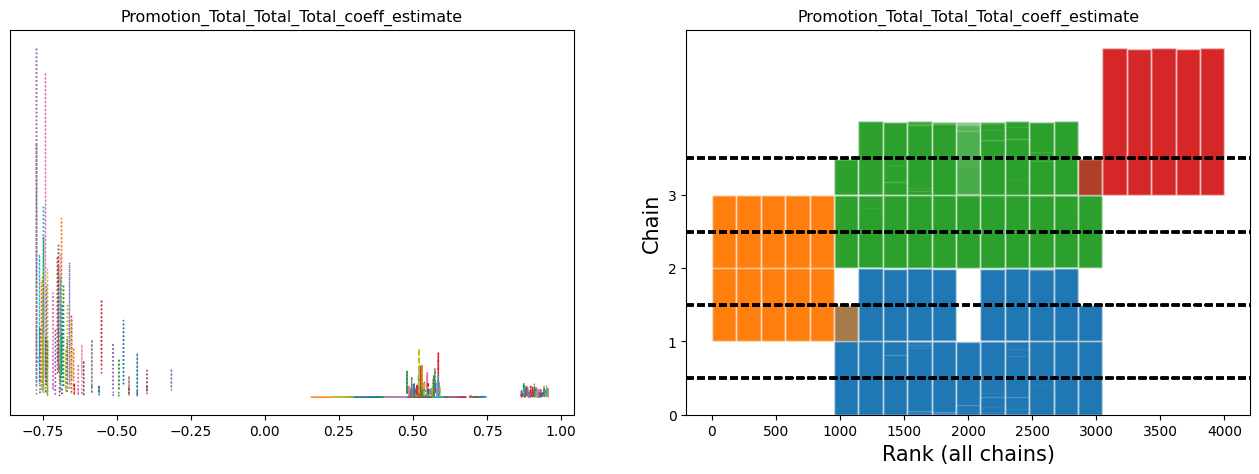

In [19]:
my_model.plot_posterior(
    varname=["Promotion_Total_Total_Total"]
);
# The plots on the left define the distribution of the parameters,
# while the plots on the right shows how well the sampler converged.
# The bars should be close to each other

Sampling: [Sales_Total_Total_Total_likelihood]


Output()

/home/mattr/BayesInsight/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mattr/BayesInsight/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


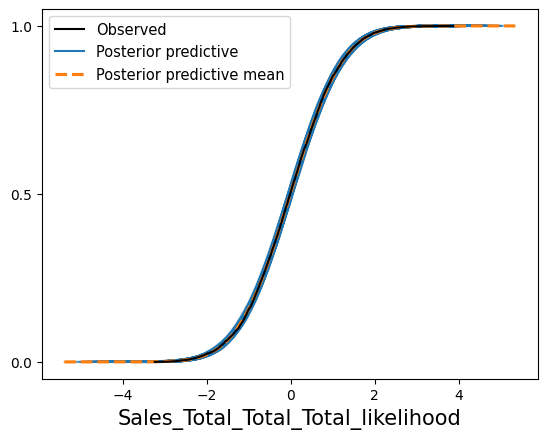

In [22]:
my_model.plot_posterior_predictive();  # This might take some time

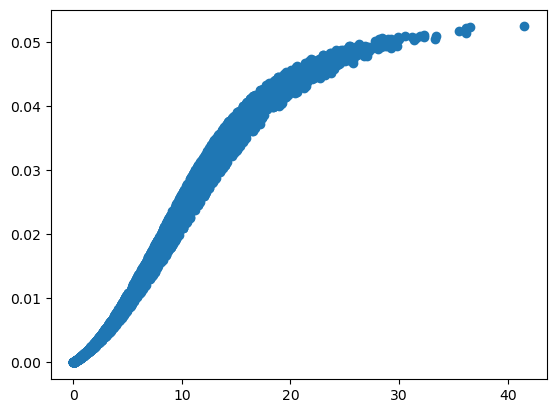

In [ ]:
# my_model.plot_posterior_curve("media_var_0_Total_Total_Total")

In [9]:
avm = my_model.avm()
avm.head()

Sampling: [Sales_Total_Total_Total_likelihood]


Output()

,Geography,Product,Period,Sales_Total_Total_Total,Sales_Total_Total_Total_likelihood,mu
0,AU,Desktops,2020-04-06,0.051555,0.005161,0.000422
1,AU,Desktops,2020-04-13,1.153100,-0.016807,-0.017483
2,AU,Desktops,2020-04-20,0.791275,-0.014248,-0.023711
3,AU,Desktops,2020-04-27,0.174080,-0.040555,-0.034253
4,AU,Desktops,2020-05-04,-0.680308,-0.066320,-0.038991


<Axes: title={'center': 'Sales in AU for Desktops'}, xlabel='Period'>

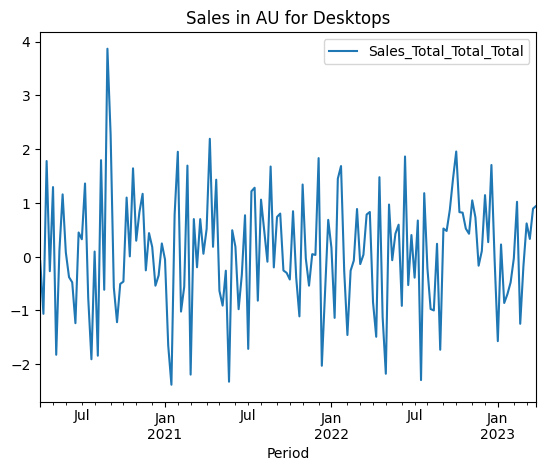

In [ ]:
avm.query("Geography == 'US' and Product == 'Desktops'").plot(x="Period", y='Sales_Total_Total_Total', kind='line', title="Sales in AU for Desktops")

In [11]:
contributions = my_model.get_contributions()
contributions.head()

AttributeError: 'BayesInsightModel' object has no attribute 'return_media_variables'

In [14]:
my_model.model_af().head()

,Geography,Product,Period,Promotion_Total_Total_Total,media_var_0_Total_Total_Total,Stock_Total_Total_Total
0,AU,Desktops,2020-04-06,1.041951,2.116320,14.0
1,AU,Desktops,2020-04-13,0.726187,14.524069,5.0
2,AU,Desktops,2020-04-20,-1.076217,4.238416,5.0
3,AU,Desktops,2020-04-27,-0.646932,2.504433,6.0
4,AU,Desktops,2020-05-04,0.212854,4.069366,10.0


In [28]:
contribution_actuals = contributions.merge(
    my_model.model_af(), on=my_model.data.metadata.row_ids
)

In [17]:
contribution_actuals.head()

,Geography,Product,Period,intercept_contribution,Promotion_Total_Total_Total_contribution,media_var_0_Total_Total_Total_contribution,Promotion_Total_Total_Total,media_var_0_Total_Total_Total,Stock_Total_Total_Total
0,AU,Desktops,2020-04-06,2.03053,0.343454,0.003090,1.041951,2.116320,14.0
1,AU,Desktops,2020-04-13,2.03053,0.239370,0.035840,0.726187,14.524069,5.0
2,AU,Desktops,2020-04-20,2.03053,-0.354749,0.007704,-1.076217,4.238416,5.0
3,AU,Desktops,2020-04-27,2.03053,-0.213245,0.003833,-0.646932,2.504433,6.0
4,AU,Desktops,2020-05-04,2.03053,0.070162,0.007292,0.212854,4.069366,10.0


In [20]:
from itertools import product

In [31]:
sorted(
    tuple(contribution_actuals[id_].unique() for id_ in ["Geography", "Product"]),
    key=len,
    reverse=True,
)

[array(['AU', 'BR', 'CA', 'DE', 'FR', 'JP', 'KR', 'MX', 'UK', 'US'],
       dtype=object),
 array(['Desktops', 'Laptops', 'Phones', 'Tablets', 'Watches'],
       dtype=object)]

In [64]:
def plot_contributions_vs_actuals(model):
    contribution_actuals = model.get_contributions().merge(
        model.model_af(), on=model.data.metadata.row_ids
    )
    pairs = [
        (col, col.replace("_contribution", ""))
        for col in contribution_actuals.columns
        if "_contribution" in col and "intercept" not in col
    ]
    row_id = [row for row in model.data.metadata.row_ids if row != "Period"]
    unique_values = tuple(contribution_actuals[id_].unique() for id_ in row_id)
    lens = [len(values) for values in unique_values]

    for pair in pairs:
        fig, axs = plt.subplots(*lens, figsize=(20, 20), layout="constrained")
        for i, values in enumerate(product(*unique_values)):
            data = contribution_actuals
            for id_, value in zip(row_id, values):
                data = data[data[id_] == value]
            ax = axs.flatten()[i]
            ax.scatter(
                contribution_actuals[pair[1]],
                contribution_actuals[pair[0]],
                color="gray",
                alpha=0.05,
                s=2,
            )
            ax.scatter(data[pair[1]], data[pair[0]], color="blue", s=2)
            ax.set_xlabel(pair[1])
            ax.set_ylabel("Contribution")
            ax.set_title(" x ".join(values))
        plt.suptitle(f"{pair[1]} vs Contribution")
        # ax.set_title(", ".join(f"{id_}: {value}" for id_, value in zip(row_id, values)))
        # ax.plot(data[pair[1]], data[pair[1]], color="red")
        # plt.tight_layout()
        plt.show()

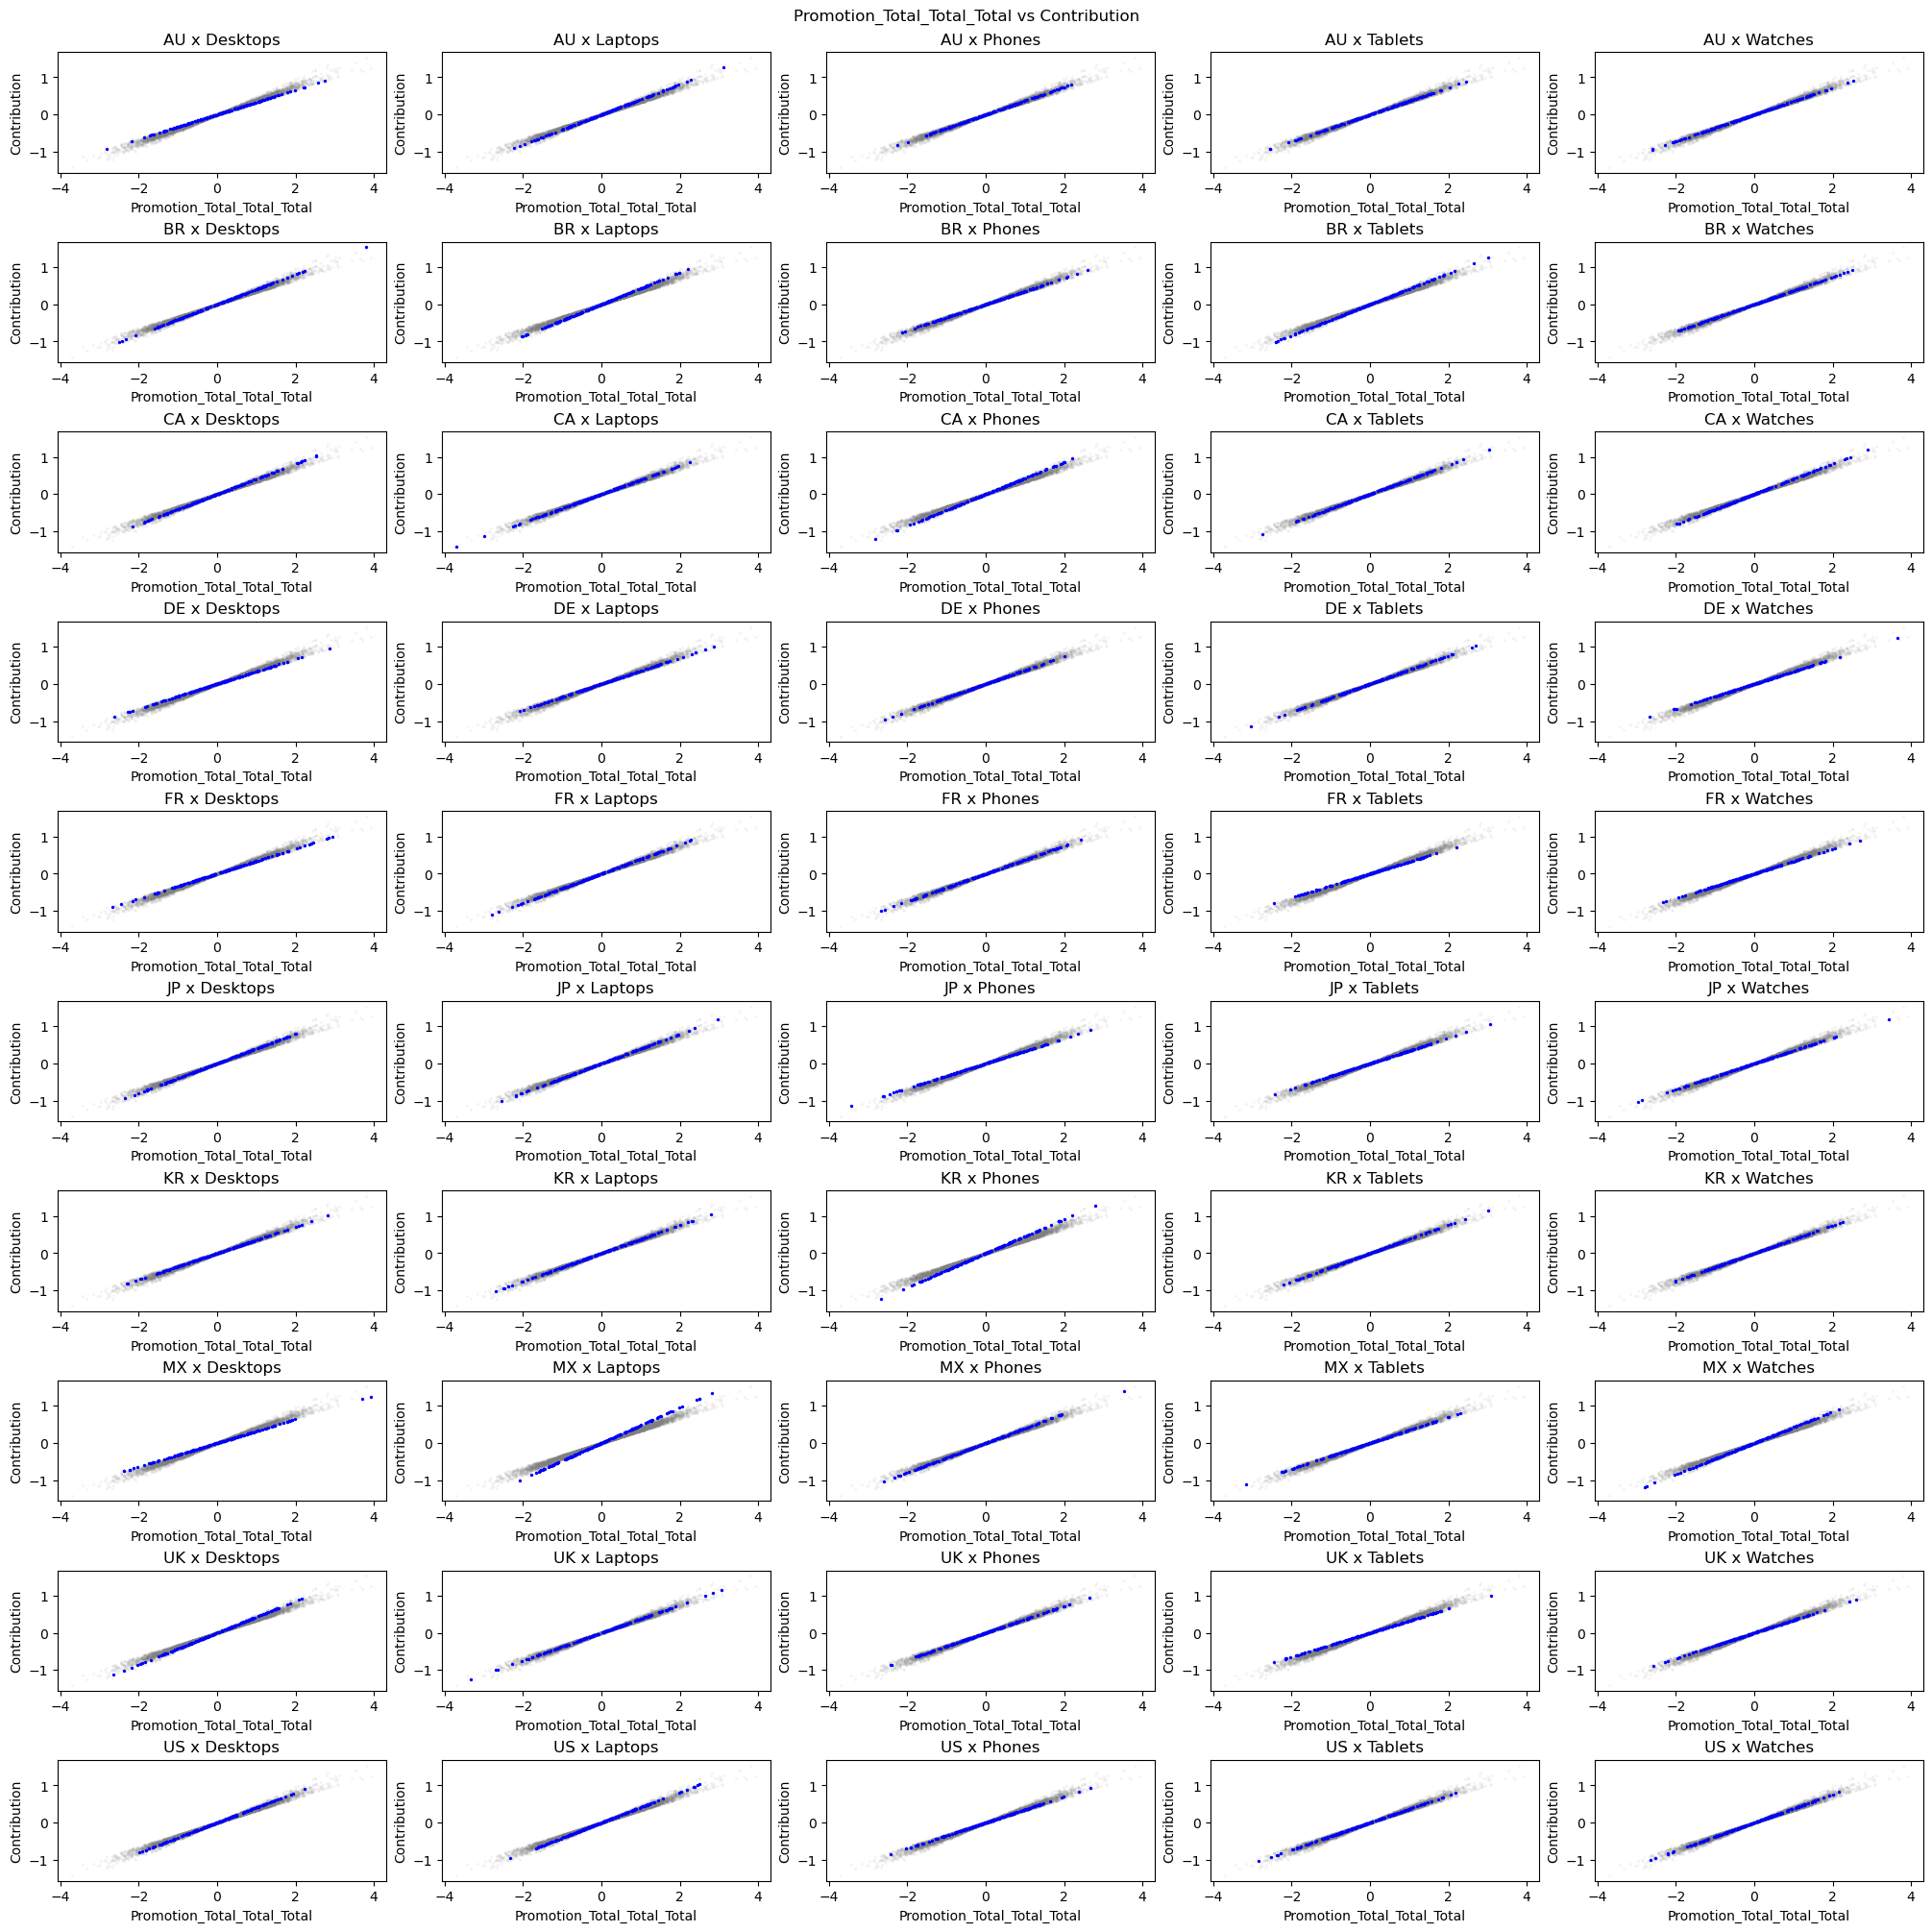

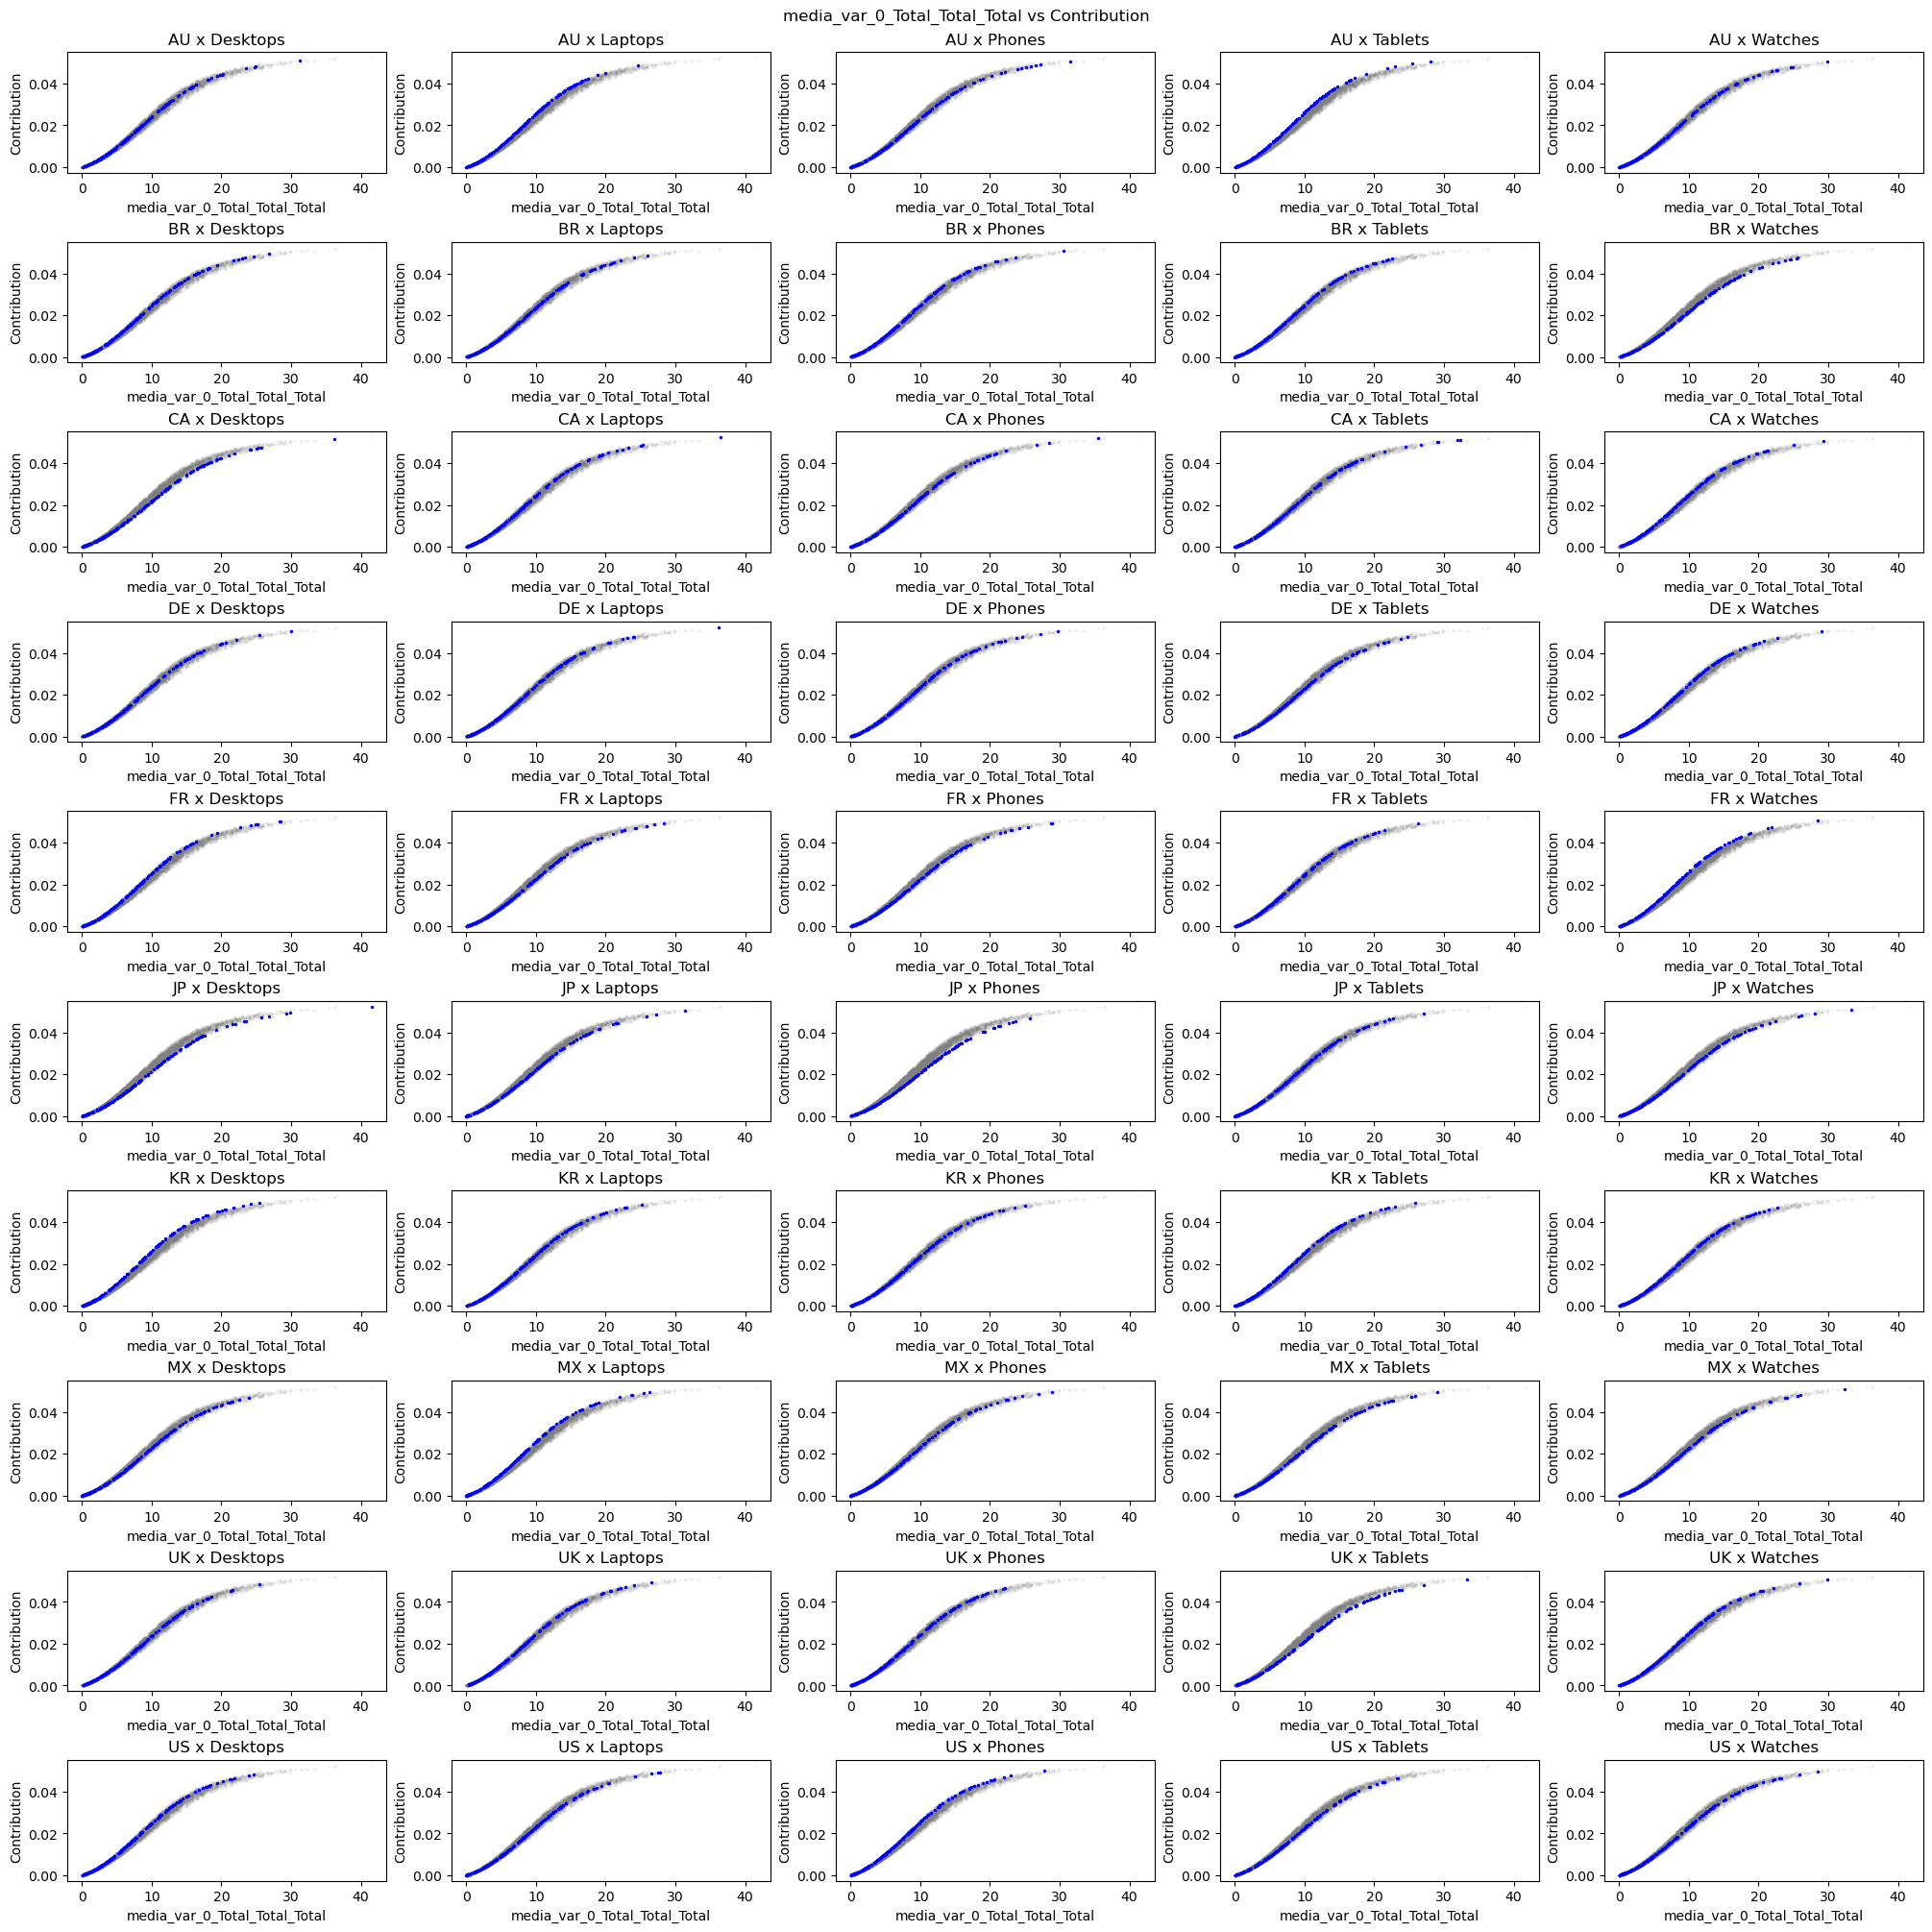

In [65]:
plot_contributions_vs_actuals(my_model)

## You can also directly examine the trace to further examine the posterior

In [17]:
my_model.trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

## Finally you can save the model

In [16]:
my_model.save("final_model")

/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/pydantic/main.py:352: UserWarning: Pydantic serializer warnings:
  Expected `tuple[literal['Geography','Period','Product','Outlet','Campaign','Creative'], ...]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_json(
